# Introduction to Deep Learning - Final Project

Peer-graded Assignment: Model Selection for Multiple Linear Regression

## 0. Introduction

This notebook contains the final project of the course Introduction to Machien Learning: Supervised Learning. In this notebook, model selection techniques are applied to obtian an optimal multiple linear regression model. The original data can be downloaded at "https://archive.ics.uci.edu/dataset/182/concrete+slump+test". The notebook is created in Kaggle with uploaded dataset. 

The notebook contains the following parts:

1. Exploratory data analysis

2. Model Selection by Non-parametric and Parametric Methods

3. General Solution for Model Selection

4. Conclusions

I have also created an R notebook for the same work.

## 1. EDA 

### 1.1 Loading data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/concrete-data/concrete.data


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from itertools import combinations
import statsmodels.api as sm
from scipy import stats

In [3]:
# Load Data
concrete_data = pd.read_csv('/kaggle/input/concrete-data/concrete.data')

### 1.2 Exploration

Before looking into the data, let us check the meanings of the column variables.

| Column Name         | Units     | Description |
|:--------------------|:----------|:------------|
| **Cement**           | kg/m³     | Amount of cement in the concrete mix. |
| **Slag**             | kg/m³     | Amount of blast furnace slag (used as partial cement replacement). |
| **Fly ash**          | kg/m³     | Amount of fly ash (another pozzolanic material, also replaces cement). |
| **Water**            | kg/m³     | Amount of water used in the mix. |
| **Superplasticizer** | kg/m³     | Amount of superplasticizer (chemical additive to improve workability). |
| **Coarse Aggregate** | kg/m³     | Amount of coarse aggregates (gravel-sized stones). |
| **Fine Aggregate**   | kg/m³     | Amount of fine aggregates (sand). |
| **Slump**            | cm        | Traditional slump test value: vertical settlement of concrete (measure of flowability). |
| **Flow**             | cm        | Flow table test value: spread diameter (more accurate for highly fluid concrete). |
| **Compressive Strength** | MPa | Compressive strength of the concrete after 28 days of curing. |

In this case, the flow is the response, while the others are predictors.


In [4]:
# Drop first column and rename the predictors
data = concrete_data.iloc[:, 1:]
data.columns = ["cement", "slag", "ash", "water", "sp", "course.agg", "fine.agg", "slump", "flow", "strength"]

The exploration contains:
1. Basic check (including numbers, sizes, missing values, abnormal values)
2. Blance check (if the categories are representative for all the categories)
3. Characteristic check for differences (through color distributions)

In [5]:
print(data.head())
print(data.describe())
print(data.isnull().sum())

   cement   slag    ash  water    sp  course.agg  fine.agg  slump  flow  \
0   273.0   82.0  105.0  210.0   9.0       904.0     680.0   23.0  62.0   
1   163.0  149.0  191.0  180.0  12.0       843.0     746.0    0.0  20.0   
2   162.0  148.0  191.0  179.0  16.0       840.0     743.0    1.0  20.0   
3   162.0  148.0  190.0  179.0  19.0       838.0     741.0    3.0  21.5   
4   154.0  112.0  144.0  220.0  10.0       923.0     658.0   20.0  64.0   

   strength  
0     34.99  
1     41.14  
2     41.81  
3     42.08  
4     26.82  
           cement        slag         ash       water          sp  \
count  103.000000  103.000000  103.000000  103.000000  103.000000   
mean   229.894175   77.973786  149.014563  197.167961    8.539806   
std     78.877230   60.461363   85.418080   20.208158    2.807530   
min    137.000000    0.000000    0.000000  160.000000    4.400000   
25%    152.000000    0.050000  115.500000  180.000000    6.000000   
50%    248.000000  100.000000  164.000000  196.0000

The results shows the dataset is clean. Now it is for exploring characteristics. First, let us check the distributions of variables by scatterplots and histgrams.

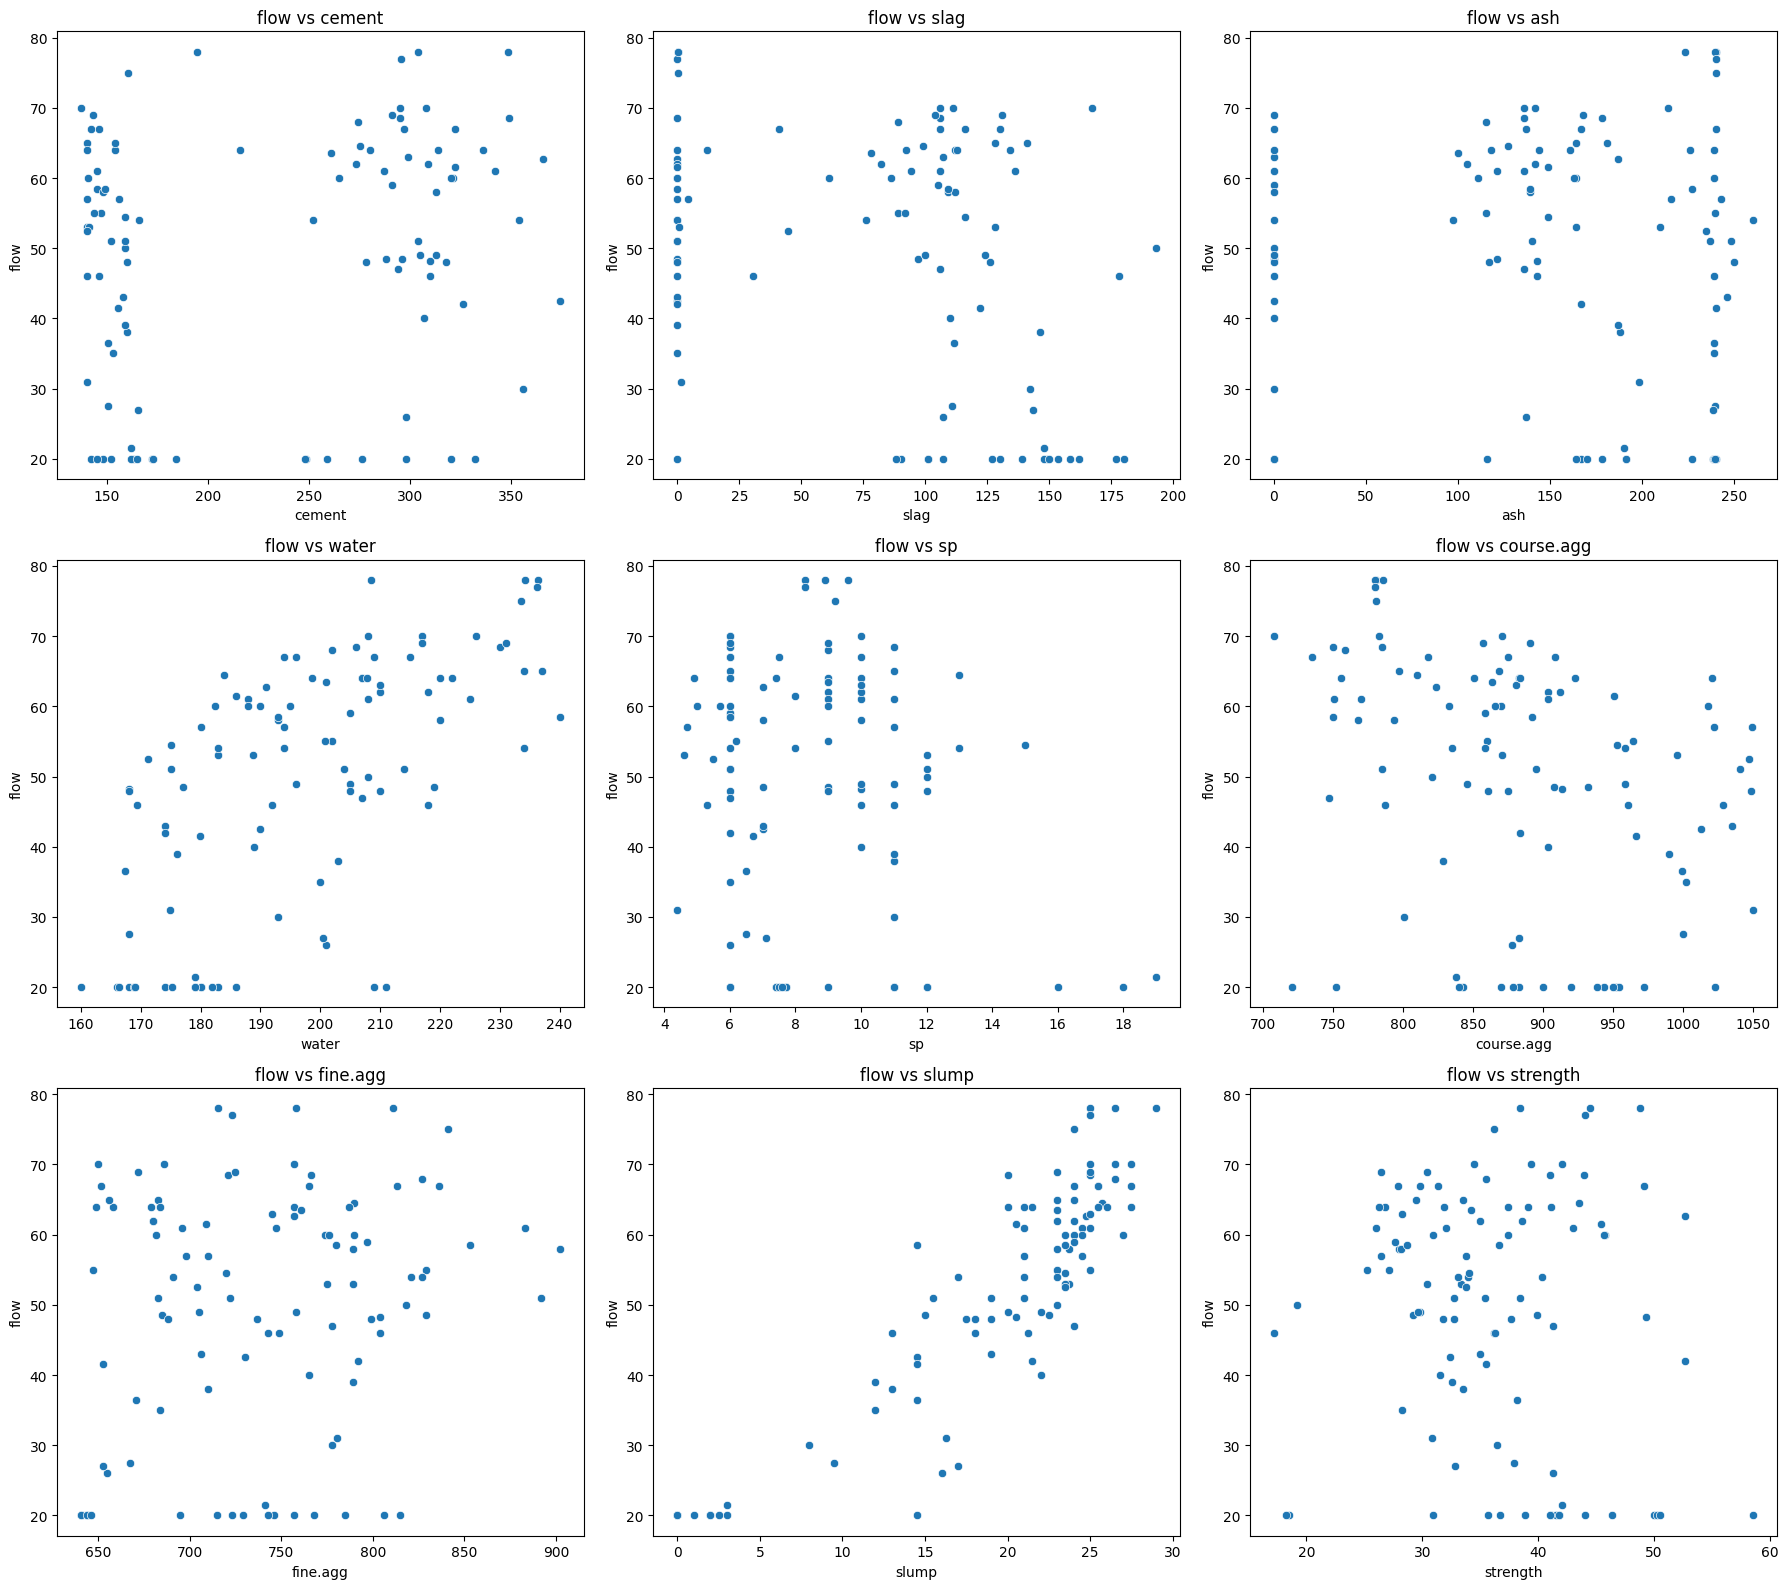

In [6]:
# Scatterplots
predictors = ["cement", "slag", "ash", "water", "sp", "course.agg", "fine.agg", "slump", "strength"]
fig, axs = plt.subplots(3, 3, figsize=(18, 16))
axs = axs.ravel()

for i, predictor in enumerate(predictors):
    sns.scatterplot(x=data[predictor], y=data["flow"], ax=axs[i])
    axs[i].set_title(f"flow vs {predictor}")

plt.tight_layout()
plt.show()

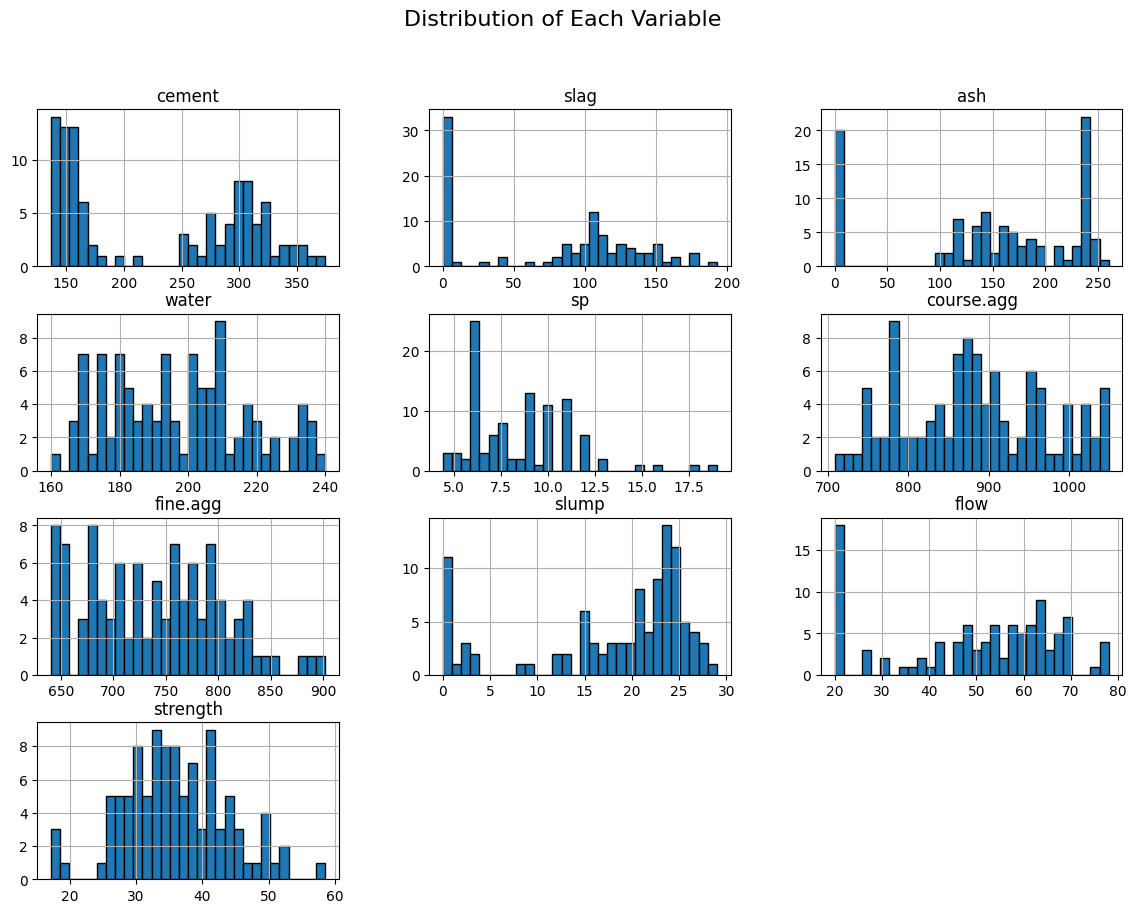

In [7]:
# Histograms
# import warnings
# warnings.filterwarnings('ignore')

data.hist(figsize=(14, 10), bins=30, edgecolor='black')
plt.suptitle("Distribution of Each Variable", fontsize=16)
plt.show()

The results shows the data of each variables are generally evenly spreaded. Although there seems to be some outliers (such as in ash columns). But I would accept it since corresponding domain knowledge is unavaible. The next is to find the correlations between variables.

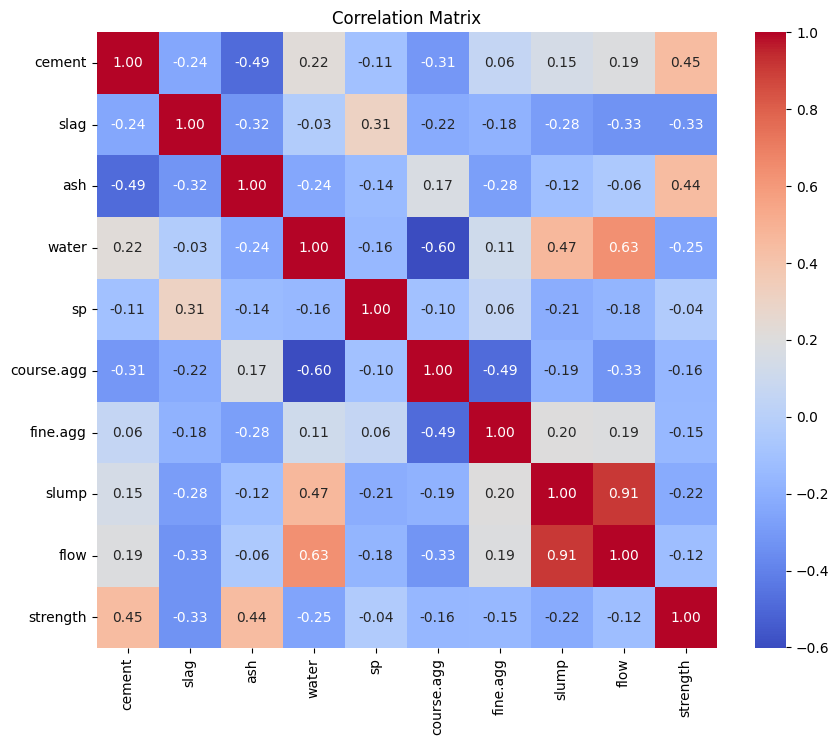

In [8]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

Generally, absolute of correlation value larger than 0.7 indicates strong correlation. The results show there exist very strong correlations, such as flow and slump. There also exists some moderate correlations, such as water vs course.agg. Hence, it suggests some of the predictors are potentially not significant in a multiple lienar regression model.

### 1.3 EDA summary

From the exploratory data analysis, the dataset is cleaned, and there exists potential non-significant predictors.

## 2. Model Selection by Non-parametric Methods

In this part, three non-parametric methods are applied:
1. Forward selection: Add most significant predictors gradually to the null model until no more significant predictors.
2. Backward selection: Remove most non-significant predictors from the full model unitl no more is nonsignificant.
3. Stepwise: Swing between the above two selection methods until no predictors can be added or removed.

Also, there parametric methods are applied:
1. Akaike Information Criterion (AIC): Balance between number of predictors $k$ vs likelihood $L$ by
   $$
   \text{AIC} = 2k - 2\ln(\hat{L})
   $$
3. Bayesian Information Criterion (BIC): Similar to AIC, but penalizes predictors more for large sample size $n$
   $$
   \text{BIC} = \ln(n)k - 2\ln(\hat{L})
   $$
3. Adjusted $R^2$: Adjusting the $R^2$ for the number of predictors
   $$
   \text{Adjusted } R^2 = 1 - \left(1 - R^2\right)\frac{n - 1}{n - k - 1}
   $$

Compared to the non-parametric, the parametric methods all evaluate between similarity and goodness of fit.

### 2.1 Full model

Let us build a full model first. The result shows not all predictors are significant.

In [9]:
# Predictors and response
predictors = ["cement", "slag", "ash", "water", "sp", "course.agg", "fine.agg", "slump", "strength"]
X = data[predictors]
y = data['flow']
X_with_const = sm.add_constant(X) # Add constant to X

# Fit the full model
model_full = sm.OLS(y, X_with_const).fit()

# View summary
print(model_full.summary())

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     97.89
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           1.82e-43
Time:                        07:22:38   Log-Likelihood:                -319.90
No. Observations:                 103   AIC:                             659.8
Df Residuals:                      93   BIC:                             686.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -175.3033    158.105     -1.109      0.2

In [10]:
# Add constant to X
X_with_const = sm.add_constant(X)

# Fit the full model
model_full = sm.OLS(y, X_with_const).fit()

# View summary
print(model_full.summary())

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     97.89
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           1.82e-43
Time:                        07:22:38   Log-Likelihood:                -319.90
No. Observations:                 103   AIC:                             659.8
Df Residuals:                      93   BIC:                             686.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -175.3033    158.105     -1.109      0.2

Non-parametric

### 2.2 Applying non-parametric model selection methods

Based on the methodologies, let us create three functions for the methods.

In [11]:
# Forward Selection
def forward_selection(X, y):
    remaining_features = list(X.columns)
    selected_features = []
    best_adj_r2 = -np.inf
    models = []

    while remaining_features:
        scores = []
        for feature in remaining_features:
            features_to_test = selected_features + [feature]
            X_train = sm.add_constant(X[features_to_test])
            model = sm.OLS(y, X_train).fit()
            scores.append((model.rsquared_adj, feature, model))

        scores.sort(reverse=True)
        if scores[0][0] > best_adj_r2:
            best_adj_r2, best_feature, best_model = scores[0]
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            models.append((selected_features.copy(), best_model))
        else:
            break

    return models

forward_model = forward_selection(X, y)

In [12]:
# Backward Selection
def backward_selection(X, y):
    selected_features = list(X.columns)
    best_adj_r2 = -np.inf
    models = []

    while selected_features:
        scores = []
        for combo in combinations(selected_features, len(selected_features)-1):
            X_train = sm.add_constant(X[list(combo)])
            model = sm.OLS(y, X_train).fit()
            scores.append((model.rsquared_adj, combo, model))

        scores.sort(reverse=True)
        if scores[0][0] > best_adj_r2:
            best_adj_r2, best_combo, best_model = scores[0]
            selected_features = list(best_combo)
            models.append((selected_features.copy(), best_model))
        else:
            break

    return models

backward_model = backward_selection(X, y)

In [13]:
# Stepwise Selection
def stepwise_selection(X, y):
    remaining_features = list(X.columns)
    selected_features = []
    current_score = -np.inf
    models = []

    while True:
        changed = False
        scores_with_candidates = []

        # Forward Step
        for feature in remaining_features:
            features_to_test = selected_features + [feature]
            X_train = sm.add_constant(X[features_to_test])
            model = sm.OLS(y, X_train).fit()
            scores_with_candidates.append((model.rsquared_adj, feature, model))

        if scores_with_candidates:
            scores_with_candidates.sort(reverse=True)
            best_new_score, best_candidate, best_model = scores_with_candidates[0]
            if best_new_score > current_score:
                remaining_features.remove(best_candidate)
                selected_features.append(best_candidate)
                current_score = best_new_score
                models.append((selected_features.copy(), best_model))
                changed = True

        # Backward Step
        if len(selected_features) > 1:
            scores_with_candidates = []
            for feature in selected_features:
                features_to_test = selected_features.copy()
                features_to_test.remove(feature)
                X_train = sm.add_constant(X[features_to_test])
                model = sm.OLS(y, X_train).fit()
                scores_with_candidates.append((model.rsquared_adj, feature, model))

            scores_with_candidates.sort(reverse=True)
            best_new_score, worst_feature, best_model = scores_with_candidates[0]
            if best_new_score > current_score:
                selected_features.remove(worst_feature)
                remaining_features.append(worst_feature)
                current_score = best_new_score
                models.append((selected_features.copy(), best_model))
                changed = True

        if not changed:
            break

    return models

stepwise_model = stepwise_selection(X, y)

Then let us check the result.

In [14]:
# Summary of Best Models
print("\nBest Forward Selection Model:")
print(forward_model[-1][1].summary())

print("\nBest Backward Selection Model:")
print(backward_model[-1][1].summary())

print("\nBest Stepwise Selection Model:")
print(stepwise_model[-1][1].summary())


Best Forward Selection Model:
                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     150.0
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           1.73e-46
Time:                        07:22:38   Log-Likelihood:                -320.39
No. Observations:                 103   AIC:                             654.8
Df Residuals:                      96   BIC:                             673.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -44.0149

### 2.3 Applying Parametic Model Methods

First, let us modify the stepwise function for hosting the AIC, and BIC criterion.

In [15]:
def stepwise_selection_aic(X, y):
    remaining_features = list(X.columns)
    selected_features = []
    current_aic = np.inf
    models = []

    while True:
        changed = False
        # Forward step
        scores_with_candidates = []
        for feature in remaining_features:
            features_to_test = selected_features + [feature]
            X_train = sm.add_constant(X[features_to_test])
            model = sm.OLS(y, X_train).fit()
            scores_with_candidates.append((model.aic, feature, model))

        if scores_with_candidates:
            scores_with_candidates.sort()
            best_new_aic, best_candidate, best_model = scores_with_candidates[0]
            if best_new_aic < current_aic:
                remaining_features.remove(best_candidate)
                selected_features.append(best_candidate)
                current_aic = best_new_aic
                models.append((selected_features.copy(), best_model))
                changed = True

        # Backward step
        if len(selected_features) > 1:
            scores_with_candidates = []
            for feature in selected_features:
                features_to_test = selected_features.copy()
                features_to_test.remove(feature)
                X_train = sm.add_constant(X[features_to_test])
                model = sm.OLS(y, X_train).fit()
                scores_with_candidates.append((model.aic, feature, model))

            scores_with_candidates.sort()
            best_new_aic, worst_feature, best_model = scores_with_candidates[0]
            if best_new_aic < current_aic:
                selected_features.remove(worst_feature)
                remaining_features.append(worst_feature)
                current_aic = best_new_aic
                models.append((selected_features.copy(), best_model))
                changed = True

        if not changed:
            break

    return models


In [16]:
def stepwise_selection_bic(X, y):
    n = X.shape[0]  # number of observations
    remaining_features = list(X.columns)
    selected_features = []
    current_bic = np.inf
    models = []

    while True:
        changed = False
        # Forward step
        scores_with_candidates = []
        for feature in remaining_features:
            features_to_test = selected_features + [feature]
            X_train = sm.add_constant(X[features_to_test])
            model = sm.OLS(y, X_train).fit()
            scores_with_candidates.append((model.bic, feature, model))

        if scores_with_candidates:
            scores_with_candidates.sort()
            best_new_bic, best_candidate, best_model = scores_with_candidates[0]
            if best_new_bic < current_bic:
                remaining_features.remove(best_candidate)
                selected_features.append(best_candidate)
                current_bic = best_new_bic
                models.append((selected_features.copy(), best_model))
                changed = True

        # Backward step
        if len(selected_features) > 1:
            scores_with_candidates = []
            for feature in selected_features:
                features_to_test = selected_features.copy()
                features_to_test.remove(feature)
                X_train = sm.add_constant(X[features_to_test])
                model = sm.OLS(y, X_train).fit()
                scores_with_candidates.append((model.bic, feature, model))

            scores_with_candidates.sort()
            best_new_bic, worst_feature, best_model = scores_with_candidates[0]
            if best_new_bic < current_bic:
                selected_features.remove(worst_feature)
                remaining_features.append(worst_feature)
                current_bic = best_new_bic
                models.append((selected_features.copy(), best_model))
                changed = True

        if not changed:
            break

    return models


In [17]:
# Run stepwise AIC selection
stepwise_aic_models = stepwise_selection_aic(X, y)

# Best model
best_stepwise_aic_model = stepwise_aic_models[-1][1]

In [18]:
# 1. Model formula
print("Model Formula:")
print('flow ~ ' + ' + '.join(best_stepwise_aic_model.model.exog_names[1:]))  # Skip 'const'

# 2. Predictors and their p-values
print("\nPredictors and their p-values:")
summary_table = pd.DataFrame({
    "Coefficient": best_stepwise_aic_model.params,
    "P-value": best_stepwise_aic_model.pvalues
})
print(summary_table)

# 3. Model performance
print("\nModel Performance Metrics:")
r_squared = best_stepwise_aic_model.rsquared
adj_r_squared = best_stepwise_aic_model.rsquared_adj
aic_value = best_stepwise_aic_model.aic
bic_value = best_stepwise_aic_model.bic

print(f"R²: {r_squared:.4f}")
print(f"Adjusted R²: {adj_r_squared:.4f}")
print(f"AIC: {aic_value:.2f}")
print(f"BIC: {bic_value:.2f}")


Model Formula:
flow ~ slump + water + strength + cement + slag + sp

Predictors and their p-values:
          Coefficient       P-value
const      -44.014854  1.758791e-07
slump        1.579029  5.298405e-36
water        0.284135  2.447631e-13
strength     0.321681  8.961603e-04
cement      -0.017525  4.509243e-02
slag        -0.025211  2.383229e-02
sp           0.410498  5.515979e-02

Model Performance Metrics:
R²: 0.9036
Adjusted R²: 0.8976
AIC: 654.78
BIC: 673.22


In [19]:
# Run stepwise BIC selection
stepwise_bic_models = stepwise_selection_bic(X, y)

# Best model
best_stepwise_bic_model = stepwise_bic_models[-1][1]


In [20]:
# odel formula
print("Model Formula:")
print('flow ~ ' + ' + '.join(best_stepwise_bic_model.model.exog_names[1:]))  # skip constant

# Predictors and their p-values
print("\nPredictors and their p-values:")
summary_table = pd.DataFrame({
    "Coefficient": best_stepwise_bic_model.params,
    "P-value": best_stepwise_bic_model.pvalues
})
print(summary_table)

# Model performance
print("\nModel Performance Metrics:")
r_squared = best_stepwise_bic_model.rsquared
adj_r_squared = best_stepwise_bic_model.rsquared_adj
aic_value = best_stepwise_bic_model.aic
bic_value = best_stepwise_bic_model.bic

print(f"R²: {r_squared:.4f}")
print(f"Adjusted R²: {adj_r_squared:.4f}")
print(f"AIC: {aic_value:.2f}")
print(f"BIC: {bic_value:.2f}")


Model Formula:
flow ~ slump + water + strength

Predictors and their p-values:
          Coefficient       P-value
const      -39.790969  2.474074e-07
slump        1.603219  1.136393e-38
water        0.253982  9.773582e-12
strength     0.288260  3.057503e-04

Model Performance Metrics:
R²: 0.8923
Adjusted R²: 0.8890
AIC: 660.20
BIC: 670.74


For applying the adjusted $R^2$ method, let us go over possible formula and choose a best one (with lowest adjusted $R^2$).

In [21]:
def best_subset_selection(X, y, max_features=10):
    n_features = X.shape[1]
    results = []

    for k in range(1, max_features + 1):
        for combo in combinations(range(n_features), k):
            X_combo = X.iloc[:, list(combo)]
            X_combo = sm.add_constant(X_combo)
            model = sm.OLS(y, X_combo).fit()
            rss = ((model.predict(X_combo) - y) ** 2).sum()
            aic = model.aic
            bic = model.bic
            adj_r2 = model.rsquared_adj
            results.append({
                'features': combo,
                'rss': rss,
                'aic': aic,
                'bic': bic,
                'adj_r2': adj_r2
            })
    results_df = pd.DataFrame(results)
    return results_df

In [22]:
# Run the best subset selection function
subset_results = best_subset_selection(X, y, max_features=len(predictors))

# Show the first few rows of results (optional check)
print(subset_results.head())

# Find best model based on highest Adjusted R²
best_model_index = subset_results['adj_r2'].idxmax()
best_model_info = subset_results.loc[best_model_index]

# Get selected variables
selected_feature_indices = best_model_info['features']
selected_features = X.columns[list(selected_feature_indices)]

print("Selected features based on Adjusted R²:")
print(selected_features.tolist())


  features           rss         aic         bic    adj_r2
0     (0,)  30388.334130  882.071101  887.340559  0.025211
1     (1,)  28111.729729  874.050298  879.319756  0.098239
2     (2,)  31386.210291  885.399015  890.668473 -0.006799
3     (3,)  18906.863406  833.194121  838.463579  0.393510
4     (4,)  30504.215090  882.463128  887.732586  0.021494
Selected features based on Adjusted R²:
['cement', 'slag', 'water', 'sp', 'slump', 'strength']


In [23]:
# Rebuild the best model and show the summary
X_best = sm.add_constant(X[selected_features])
model_adjr2 = sm.OLS(y, X_best).fit()

# Model formula
print("Model Formula:")
print('flow ~ ' + ' + '.join(selected_features))

# Predictors and their p-values
print("\nPredictors and their p-values:")
summary_table = pd.DataFrame({
    "Coefficient": model_adjr2.params,
    "P-value": model_adjr2.pvalues
})
print(summary_table)

# Model performance
print("\nModel Performance Metrics:")
r_squared = model_adjr2.rsquared
adj_r_squared = model_adjr2.rsquared_adj
aic_value = model_adjr2.aic
bic_value = model_adjr2.bic

print(f"R²: {r_squared:.4f}")
print(f"Adjusted R²: {adj_r_squared:.4f}")
print(f"AIC: {aic_value:.2f}")
print(f"BIC: {bic_value:.2f}")

Model Formula:
flow ~ cement + slag + water + sp + slump + strength

Predictors and their p-values:
          Coefficient       P-value
const      -44.014854  1.758791e-07
cement      -0.017525  4.509243e-02
slag        -0.025211  2.383229e-02
water        0.284135  2.447631e-13
sp           0.410498  5.515979e-02
slump        1.579029  5.298405e-36
strength     0.321681  8.961603e-04

Model Performance Metrics:
R²: 0.9036
Adjusted R²: 0.8976
AIC: 654.78
BIC: 673.22


### 2.4 Comparison

Let us summarize the results

In [24]:
def extract_model(m):
    """Fix: If m is a list, take the last model, otherwise return as is."""
    if isinstance(m, list):
        # Assume last element is best model in stepwise or subset
        return m[-1][1]
    else:
        return m

In [25]:
model_list = {
    "Full": model_full,
    "Forward": forward_model,
    "Backward": backward_model,
    "Stepwise": stepwise_model,
    "AIC": best_stepwise_aic_model,
    "BIC": best_stepwise_bic_model,
    "AdjR2": model_adjr2
}

In [26]:
rows = []

for model_name, model_obj in model_list.items():
    m = extract_model(model_obj)
    
    # Get predictors, ignoring 'const'
    predictors = [name for name in m.model.exog_names if name != 'const']
    predictors_text = ", ".join(predictors)
    
    # Model metrics
    r2 = m.rsquared
    adjr2 = m.rsquared_adj
    aic = m.aic
    bic = m.bic
    
    rows.append({
        "Model": model_name,
        "Predictors": predictors_text,
        "R2": round(r2, 4),
        "AdjR2": round(adjr2, 4),
        "AIC": round(aic, 2),
        "BIC": round(bic, 2)
    })

comparison_table = pd.DataFrame(rows)
print(comparison_table)

      Model                                         Predictors      R2  \
0      Full  cement, slag, ash, water, sp, course.agg, fine...  0.9045   
1   Forward           slump, water, strength, cement, slag, sp  0.9036   
2  Backward  ash, water, sp, course.agg, fine.agg, slump, s...  0.9042   
3  Stepwise           slump, water, strength, cement, slag, sp  0.9036   
4       AIC           slump, water, strength, cement, slag, sp  0.9036   
5       BIC                             slump, water, strength  0.8923   
6     AdjR2           cement, slag, water, sp, slump, strength  0.9036   

    AdjR2     AIC     BIC  
0  0.8953  659.79  686.14  
1  0.8976  654.78  673.22  
2  0.8971  656.18  677.26  
3  0.8976  654.78  673.22  
4  0.8976  654.78  673.22  
5  0.8890  660.20  670.74  
6  0.8976  654.78  673.22  


The results shows the BIC-based model gives optimal goodness of fit, but the difference between these methods are very small.

## 3. General Solution for Model Selection

In this part, a general solution is provides. The method have two steps:
1. Iterate from the combinations of predictors under a specific selection of predictor number, and get a candidate model under a spefic number of predictors.
2. Compare the different models and choose the best one for the multiple linear regression.

In [27]:
predictors = ["cement", "slag", "ash", "water", "sp", "course.agg", "fine.agg", "slump", "strength"]
X = data[predictors]  
y = data['flow']

def best_subset_selection_best_model_per_size(X, y, max_features=10):
    n_features = X.shape[1]
    feature_names = X.columns.tolist()
    results = []

    for k in range(1, max_features + 1):
        best_adj_r2 = -np.inf
        best_model = None
        best_combo = None

        for combo in combinations(range(n_features), k):
            X_combo = X.iloc[:, list(combo)]
            X_combo = sm.add_constant(X_combo)
            model = sm.OLS(y, X_combo).fit()
            adj_r2 = model.rsquared_adj

            if adj_r2 > best_adj_r2:
                best_adj_r2 = adj_r2
                best_model = model
                best_combo = combo

        # Build inclusion row for the best model at this size
        included = {name: (i in best_combo) for i, name in enumerate(feature_names)}
        included["(Intercept)"] = True  # Always include intercept
        included["rss"] = ((best_model.predict(sm.add_constant(X.iloc[:, list(best_combo)])) - y) ** 2).sum()
        included["aic"] = best_model.aic
        included["bic"] = best_model.bic
        included["adj_r2"] = best_model.rsquared_adj

        results.append(included)

    results_df = pd.DataFrame(results)
    return results_df

In [28]:
X = data[predictors]  # ✅ Make sure predictors has all 9 predictors
y = data['flow']

subset_selection_best = best_subset_selection_best_model_per_size(X, y, max_features=len(predictors))

# Arrange columns properly
columns_order = ["(Intercept)"] + predictors
subset_inclusion = subset_selection_best[columns_order]
print(subset_inclusion)

   (Intercept)  cement   slag    ash  water     sp  course.agg  fine.agg  \
0         True   False  False  False  False  False       False     False   
1         True   False  False  False   True  False       False     False   
2         True   False  False  False   True  False       False     False   
3         True    True  False  False   True  False       False     False   
4         True    True   True  False   True  False       False     False   
5         True    True   True  False   True   True       False     False   
6         True   False  False   True   True   True        True      True   
7         True   False   True   True   True   True        True      True   
8         True    True   True   True   True   True        True      True   

   slump  strength  
0   True     False  
1   True     False  
2   True      True  
3   True      True  
4   True      True  
5   True      True  
6   True      True  
7   True      True  
8   True      True  


In the above, the model complexity is iterated from 0 to the maximum number (corresponding to the null and full model, respectively). Now let is compare the candidates by parameters.

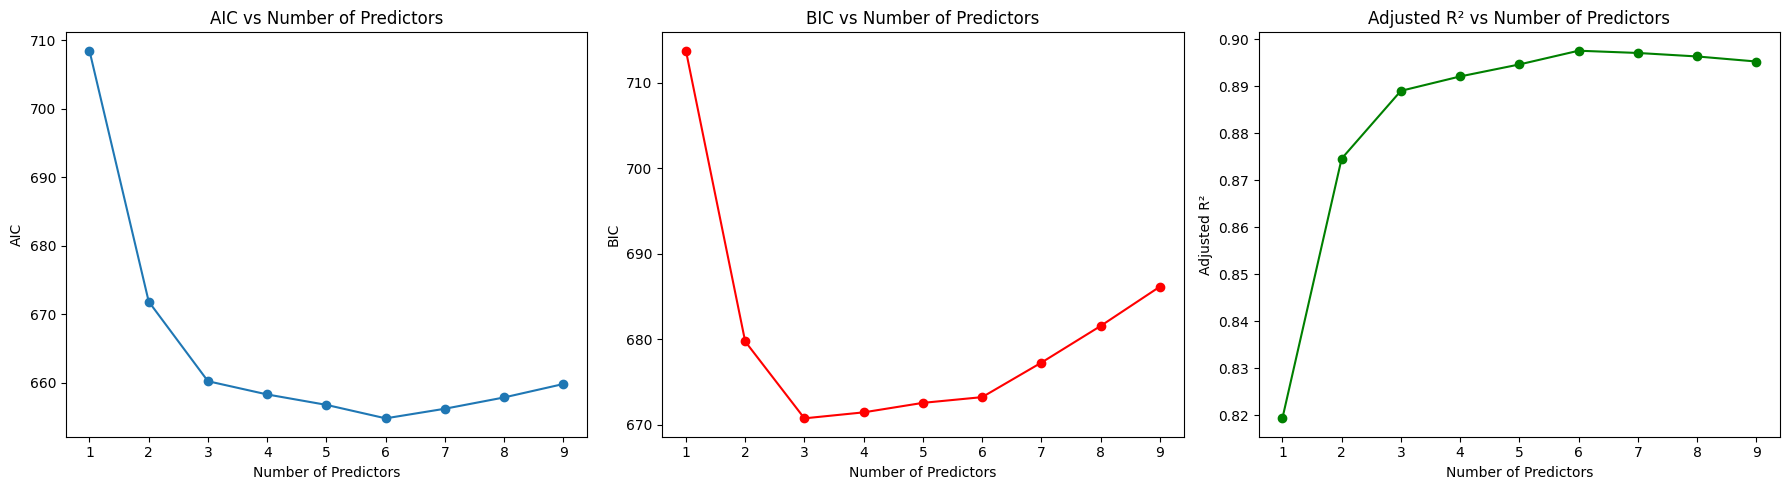

In [29]:
subset_results = best_subset_selection(X, y, max_features=len(predictors))

# Plot Model Metrics
subset_results['num_features'] = subset_results['features'].apply(len)
best_by_num_features = subset_results.groupby('num_features').agg({'aic':'min', 'bic':'min', 'adj_r2':'max'}).reset_index()

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].plot(best_by_num_features['num_features'], best_by_num_features['aic'], marker='o')
axs[0].set_title('AIC vs Number of Predictors')
axs[0].set_xlabel('Number of Predictors')
axs[0].set_ylabel('AIC')

axs[1].plot(best_by_num_features['num_features'], best_by_num_features['bic'], marker='o', color='red')
axs[1].set_title('BIC vs Number of Predictors')
axs[1].set_xlabel('Number of Predictors')
axs[1].set_ylabel('BIC')

axs[2].plot(best_by_num_features['num_features'], best_by_num_features['adj_r2'], marker='o', color='green')
axs[2].set_title('Adjusted R² vs Number of Predictors')
axs[2].set_xlabel('Number of Predictors')
axs[2].set_ylabel('Adjusted R²')

plt.tight_layout()
plt.show()

Based on the results, it can be concluded that in this case:
1. Based on the adjusted $R^2$ and AIC, six predictors would be the best for fitting the model. The formula is: flow ~ cement + slag + water + sp + slump + strength.
2. Based on BIC, three predictors would be the best for fitting the model. The formula is: flow ~ water + slump + strength.

## 4. Conclusion

In this final project, non-parametric and parametric methods are applied for selecting predictors of multiple linear regression model. The conclusions are:
1. Non-parametric mothods focus on gradually adding or removing one predictors, while parametric mothods focus on theoretical parameters. In this case, they two categories give different formula but very close goodneess of fit.
2. A general method is provided. It iterates between all combinations of predictors and then choose based on parameters.

One concern for the general method is that the combination goes too large for complex datasets. Hence, the dimension would need to be reduced before selection.